# Análisis de la sensibilidad en la topología Sallen-Key

<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Resumen 

En este notebook se analizará la respuesta en frecuencia de un **filtro pasabajo activo**, mediante el uso de las siguientes funciones:

* [analyze_sys]()
* [bodePlot]()
* [pzmap]()
* [pretty_print_bicuad_omegayq]()

Finalmente se presentará un *análisis estadístico cualitativo* de la sensibilidad de dicha respuesta a los elementos circuitales.


### Introducción


En el siguiente documento analizaremos la dispersión de parámetros $Q$, $\omega_0$ y la ganancia $K$ correspondiente a una topología Sallen-Key en su configuración pasabajo

<img src="./sallenkey.png" align="center" width="700" style="border:10px solid white" /> 



Como se analizó en clase, la transferencia de tensión está definida por la siguiente función

$$ T(s) = \frac{ K·\omega_0^2}{s^2 + s · \omega_0/Q + \omega_0^2} $$

siendo los parámetros de la transferencia en función de los componentes de la red:

$$ \omega_0^2=\frac{G_1 G_2}{C^2} $$

$$ K=1+R_B/R_A $$


$$ Q=\frac{ \sqrt{G_1 G_2}}{G_1 + G_2(2-K)} $$

Los primeros dos parámetros, $\omega_0^2$ y $K$,  no llaman la atención, pero sí la selectividad $Q$ que depende de la ganancia $K$ de una forma muy singular. Como se observa en el denominador, si la ganancia iguala o supera el valor de 2 (o 3 en el caso que $G_1=G_2=G$), el valor de $Q$ podría incrementarse demasiado, incluso en teoría comprometiendo la estabilidad de la red.  Esta sería una forma de analizarlo, sin embargo también hay otra forma, si despejamos $K$ de la expresión simplificada para $G_1=G_2=G$

$$ K= 3 - \frac{ 1}{Q} $$

Si necesitamos un filtro con un $Q$ elevado (no mucho más grande que 3), la ganancia requerida estará apenas por debajo de 3. En consecuencia, implementar $K$ mediante dos resistores ($R_A$ y $R_B$) con tolerancias comerciales resulta difícil o impracticable.


### Análisis de la Sensibilidad

Para este tipo de circuitos con dependencias restrictivas (o marginalmente problemáticas), resulta necesario estudiar en detalle cómo afectan el valor de los componentes a la transferencia total $T(s)$, o más precisamente a algún parámetro en particular: $K$, $Q$ u $\omega_0$. Este estudio se denomina **análisis de la sensibilidad**, que según se estudió en clase, analiza la dependencia lineal entre el valor del componente y el parámetro en cuestión. Para este caso, la sensibilidad de $Q$ respecto a $K$ se denomina $S_K^Q$

$$ S_K^Q =  \frac{dQ/Q}{dK/K} \approx  \frac{\Delta Q/Q}{ \Delta K/K} = 3Q - 1 $$

y se aproxima a la relación lineal entre el error relativo entre $Q$ y $K$

$$ \frac{\Delta Q}{Q} = S_K^Q . \frac{\Delta K}{K}  $$

es decir que un error relativo $\Delta K/K=5\%$, para un valor de $Q = 5$, se convierte en $\Delta Q/Q= 3 \times 15-1 = 44\%$.

Restaría analizar $S_{R_A}^K$ y $S_{R_B}^K$ para poder calcular 

$$ \frac{\Delta K}{K}= S_{R_A}^K \times \frac{\Delta R_A}{R_A} + S_{R_B}^K \times \frac{\Delta R_B}{R_B}  $$

Esto se deja para quienes tengan interés especial. 


### Análisis de Monte Carlo

Sin embargo, no es el único enfoque para estudiar la sensibilidad de una red a los elementos constructivos. Otro enfoque muy utilizado es el denominado [análisis de Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method). El mismo consta de los siguientes pasos:

1. Definir las variables independientes: sus posibles valores y distribuciones estadísticas. En caso de incertidumbre, se puede asumir una distribución **uniforme** entre dos valores límite, lo que equivale a no favorecer ningún valor en dicho intervalo, o desconocer cómo se distribuyen los valores de un proceso de fabricación.
2. Samplear o tomar al azar un valor para cada componenente de **1)**, y calcular determinísticamente la transferencia $T_i(s)$.
3. Repetir $N$ veces para acumular una cantidad significante de realizaciones. Una regla adecuada para asumir un valor de $N$ adecuado es de *10 veces la cantidad de variables independientes* definida en **1)**.

Con la población de $N$ resultados para $T_i(s)$, se procede a calcular los valores más representativos de centralidad, dispersión, y eventualmente, los casos más y menos favorables.

### Experimentación

Realizaremos un estudio de la dispersión, *estilo Monte Carlo*, de los parámetros $Q$, $\omega_0$ y $K$ muestreando valores de $C$, $R$ y $R_B$ con una distribución uniforme, definida por los valores centrales y la tolerancia de cada componente, de la siguiente manera:

* $C = 1$
* $R = 1$
* $R_B = R \times (2-\frac{1}{Q}) = 2-\frac{1}{Q}$

Siendo $\omega_0 = 1$ y $Q = 10$. Elegimos un $Q$ elevado e impracticable para acentuar las limitaciones de esta red.


Para ello se calculará la función transferencia $T_i(s)$ a partir de los 3 valores sampleados $C_i, R_i$ y $R_{Bi}$ de cada componente. Finalmente se calculan las $N$ respuestas de módulo y fase, y los valores de los parámetros de cada transferencia $Q_i$ y  $\omega_{0i}$.

Se procede a inicializar la simulación de la forma usual.

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos externos
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import TransferFunction

# Esta parte de código la agregamos SOLO en los notebooks para fijar el estilo de los gráficos.
fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi
fig_font_size = 13

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})

Separamos la inicialización del módulo pyTC2 para enfatizar las funciones concretas que se necesitan.

In [2]:
# Ahora importamos las funciones de PyTC2

from pytc2.sistemas_lineales import pzmap, GroupDelay, bodePlot, pretty_print_bicuad_omegayq
from pytc2.general import print_subtitle, print_latex, a_equal_b_latex_s


Ahora se definen las cuestiones más generales de la simulación, como:

* la cantidad de iteraciones $N$
* el comportamiento esperado de la red, es decir los parámetros $Q_0$ y $\omega_{00}$ de $T_0(s)$.
* los componentes de la red sujetos al análisis Monte Carlo y sus valores centrales $C_0, R_0$ y $R_{B0}$
* la tolerancia de cada componente (5%)

In [3]:
#################################
## parámetros de la simulación ##
#################################

# Cantidad de iteraciones o experimentos
NN = 1000
# Tolerancia de los componentes
tol = 5

# Q y \omega_0 proyectados
QQ = 10
W0 = 1

# Valores de los componentes 
CC = 1
RR = 1
RB = (2-1/QQ)*RR


La simulación continúa con el sampleo de $C_i, R_i$ y $R_{Bi}$; y finalmente, cálculo de las transferencias $T_i(s)$

#### Transferencia sampleada al azar

<IPython.core.display.Math object>

#### Transferencia deseada

<IPython.core.display.Math object>

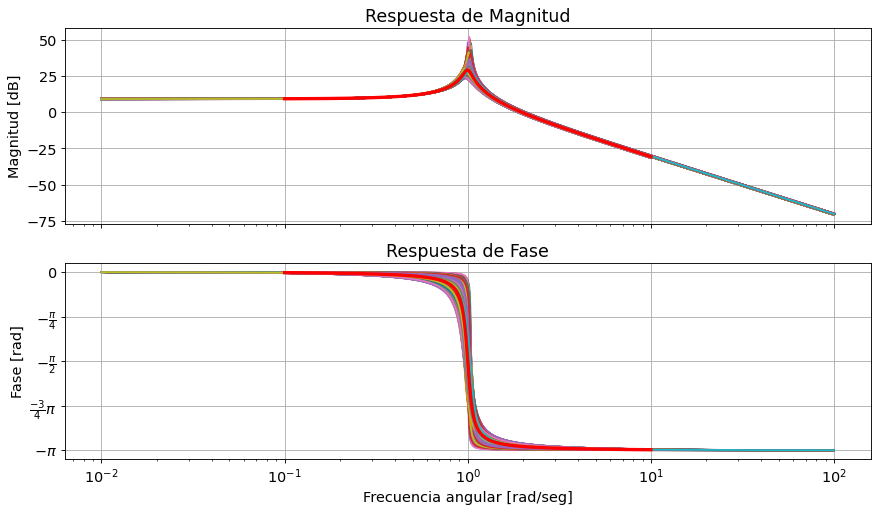

In [4]:

# Valores de los componentes para cada iteración:
# Cada valor es muestreado independientemente de una distribución uniforme,
# limitada por la tolerancia impuesta.
all_C = np.random.uniform(CC * (100-tol/2)/100 , CC * (100+tol/2)/100, size=NN )
all_R = np.random.uniform(RR * (100-tol/2)/100 , RR * (100+tol/2)/100, size=NN )
all_RB = np.random.uniform(RB * (100-tol/2)/100 , RB * (100+tol/2)/100, size=NN )

plt.close('all')

fig_hdl = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
axes_hdl = fig_hdl.subplots(2, 1, sharex='col')
fig_id = fig_hdl.number

# analizaremos cada iteración resultante
for (this_C, this_R, this_RB) in zip( all_C, all_R, all_RB):

    this_KK = 1 + this_RB/this_R
    this_QQ = 1/(3-this_KK)
    this_w0 = 1/this_R/this_C
    
    num = [this_KK * (this_w0**2)]
    den = [1, this_w0/this_QQ, this_w0**2]
    
    my_tf = TransferFunction( num, den )
    
    _, axes_hdl = bodePlot(my_tf, fig_id)


# visualizamos la última realización a modo de ejemplo
print_subtitle('Transferencia sampleada al azar')

print_latex(a_equal_b_latex_s('T_N(s)', pretty_print_bicuad_omegayq(num, den, displaystr=False)))

# finalmente ploteamos también la transferencia con los valores esperados
# sin incertidumbre alguna sobre sus valores.
KK = 1 + RB/RR
QQ = 1/(3-KK)
WW0 = 1/RR/CC

num = [KK * (WW0**2)]
den = [1, WW0/QQ, WW0**2]

# visualizamos la transferencia esperada o media
print_subtitle('Transferencia deseada')

print_latex(a_equal_b_latex_s('T_0(s)', pretty_print_bicuad_omegayq(num, den, displaystr=False)))

my_tf = TransferFunction( num, den )

w, mag, phase = my_tf.bode(n=300)

(mag_ax_hdl, phase_ax_hdl) = axes_hdl

plt.sca(mag_ax_hdl)
plt.semilogx(w, mag, '-r', linewidth=3 )    # Bode magnitude plot
    
plt.sca(phase_ax_hdl)
plt.semilogx(w, phase*np.pi/180, '-r', linewidth=3)    # Bode phase plot

plt.show()


En la respuesta de módulo y fase podemos observar la notoria dispersión de las N iteraciones de $T(s)$. En trazo rojo grueso observamos la transferencia esperada $T_0(s)$. Notar la gran dispersión en torno al valor de $\omega = 1$, donde la transferencia de módulo debería valer $20 \times \log{Q_0}$ = 20 dB. Más abajo observaremos que se alcanzan valores de $Q_i$ bien por encima de 50.

En la respuesta de fase se evidencia claramente la dispersión de $\omega_0i$, ya que este tipo de transferencia atraviesa los $-\pi/2$ radianes exactamente en $\omega_0i$.

Se continúa ahora con el análisis estadístico de cada parámetro $\omega_0$ y $Q$.

Text(0.5, 1.0, '$\\omega_0$ para cada experimento')

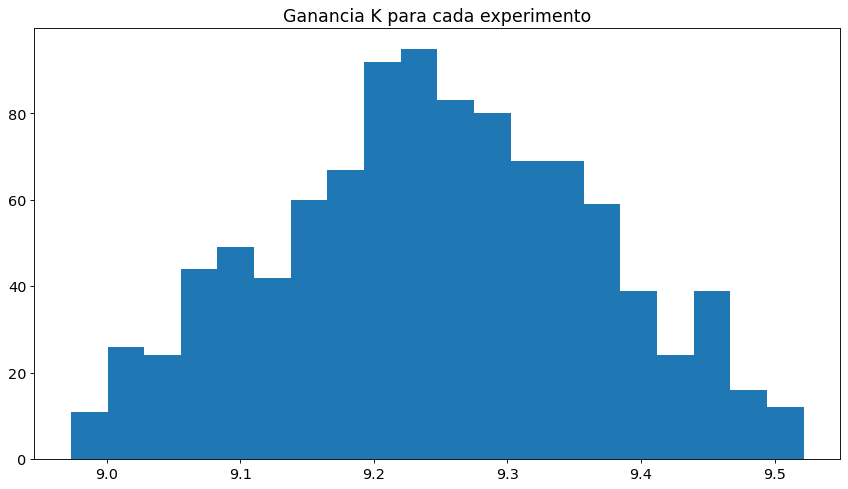

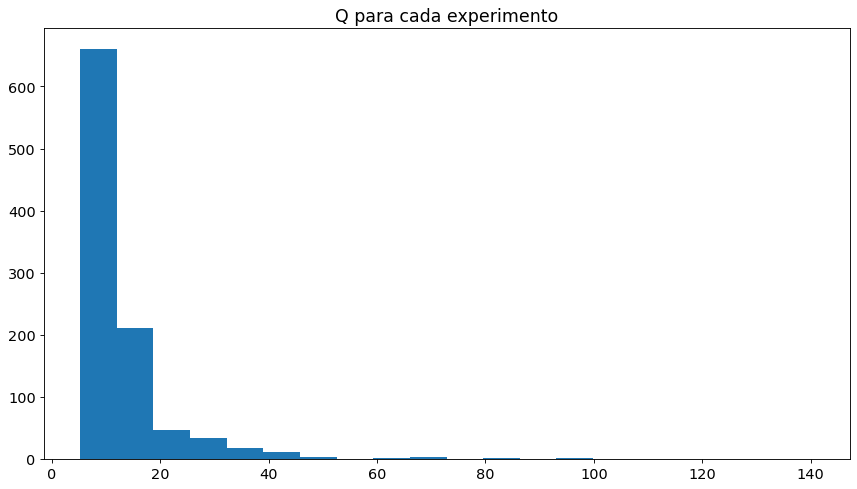

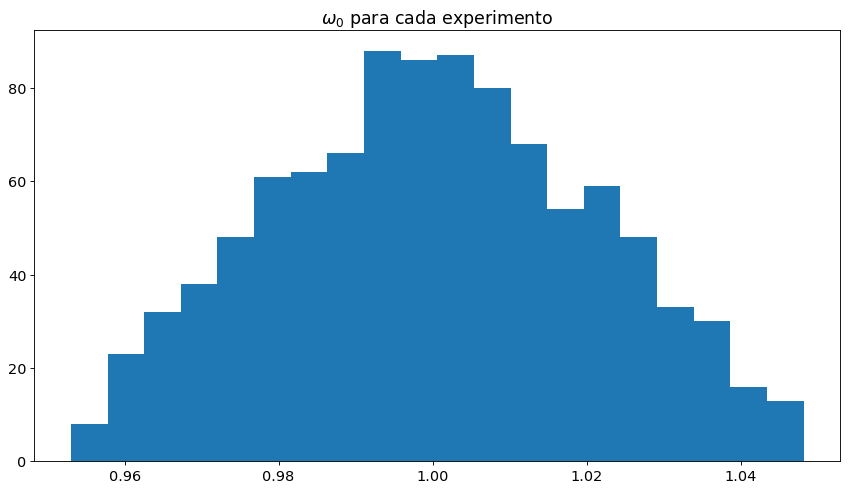

In [5]:
# Ahora vamos a hacer un estudio estadístico de los parámetros Q y \omega_0
# calculo los valores de los parámetros para TODAS las iteraciones
all_KK = 1 + all_RB/all_R
all_QQ = 1/(3-all_KK)
all_w0 = 1/all_R/all_C

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
plt.hist( 20*np.log10(all_KK), 20 )
plt.title('Ganancia K para cada experimento')

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
plt.hist( all_QQ, 20 )
plt.title('Q para cada experimento')

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
plt.hist( all_w0, 20 )
plt.title('$\omega_0$ para cada experimento')


Como se puede ver en los histogramas, el parámetro $Q$ es el más afectado o sensible en esta topología, razón por la cual habrá que ser extremadamente cuidadoso en el diseño de este tipo de redes activas. El $Q$ depende de la ganancia $k$ que a su vez depende de la relación de dos resistores. Esta alta sensibilidad puede mitigarse, o bien utilizando resistores con tolerancias bajas (<= 1%), o asumiendo que el Q a implementar sea bajo de forma tal de relajar el valor de la ganancia a implementar.